In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import os
import time
from qiskit.aqua.algorithms import NumPyEigensolver
from typing import List, NamedTuple
from qiskit.chemistry.transformations import FermionicTransformation, FermionicTransformationType, FermionicQubitMappingType
import pylab
import os
import time
from typing import List, NamedTuple

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.operators import PauliExpectation
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.operators.converters import AbelianGrouper
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator, AerProvider
from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info import Statevector
from qiskit.test.mock import *
from qiskit.visualization import plot_error_map

/Users/bavithra/miniconda3/envs/qiskit-env/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
#plt.rcParams["figure.dpi"] = 75
plt.style.use("ggplot")

In [4]:
#file_path = './qmolecule-data'
start = 0.1
step_size = 0.2
steps = 3
# bond_lengths = np.linspace(0.1, 3, steps)
basis_sets = ['sto3g', 'sto6g', '631g', 'ccpvdz']
map_types = ['JORDAN_WIGNER', 'PARITY', 'BRAVYI_KITAEV']
threshold = 0.00000001

In [5]:
drivers_0_735 = []

In [6]:
def get_qubit_hamiltonian(d, basis_set, map_type):
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(d) , unit=UnitsType.ANGSTROM, charge=0,
                             spin=0, basis=basis_set)
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    repulsion_energy = molecule.nuclear_repulsion_energy
    fermionic_op = FermionicOperator(h1,h2)
    qubit_op = fermionic_op.mapping(map_type=map_type, threshold=threshold)
    return qubit_op, repulsion_energy

In [ ]:
exact_energies  = np.empty([len(basis_sets), steps+1])
distances = np.empty(steps+1)
def exact_eigensolver(distance, basis_set, map_type):
    qubit_operator, repulsion = get_qubit_hamiltonian(distance,basis_set, map_type)
    exact_solution = NumPyEigensolver(qubit_operator).run()
    exact_energy = np.real(exact_solution.eigenvalues) + repulsion

In [ ]:
# using driver to get fermionic Hamiltonian
driver_0_735_sto3g = PySCFDriver(atom="H 0.0 0.0 0.0; H 0.0 0.0 0.735" , unit=UnitsType.ANGSTROM, charge=0,
                             spin=0, basis='sto3g')
molecule_0_735_sto3g = driver_0_735_sto3g.run()
h1_0_735_sto3g = molecule_0_735_sto3g.one_body_integrals
h2_0_735_sto3g = molecule_0_735_sto3g.two_body_integrals

In [5]:
# convert from fermionic hamiltonian to qubit hamiltonian
ferOp = FermionicOperator(h1=h1_0_735_sto3g, h2=h2_0_735_sto3g)
qubitOp_jw = ferOp.mapping(map_type='JORDAN_WIGNER', threshold=threshold)
qubitOp_pa = ferOp.mapping(map_type='PARITY', threshold=threshold)
qubitOp_bk = ferOp.mapping(map_type='BRAVYI_KITAEV', threshold=threshold)

In [6]:
# print out qubit hamiltonian in Pauli terms and exact solution
qubit_ops = [(qubitOp_jw, 'jordan wigner'),
            (qubitOp_pa, 'parity'),
            (qubitOp_bk, 'bravyi-kitaev')]

for qubit_op, name in qubit_ops:
    print("\n --- {} ---".format(name))
    print(qubit_op)


 --- jordan wigner ---
Representation: paulis, qubits: 4, size: 15

 --- parity ---
Representation: paulis, qubits: 4, size: 15

 --- bravyi-kitaev ---
Representation: paulis, qubits: 4, size: 15


In [7]:
exact_energies  = np.empty([len(basis_sets), steps+1])
distances = np.empty(steps+1)

In [8]:
fermionic_transformation = FermionicTransformation(
            transformation=FermionicTransformationType.FULL,
            qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER,
            two_qubit_reduction=False,
            freeze_core=False)

In [9]:
print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*step_size/steps
    for j in range(len(basis_sets)):
        driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(d), unit=UnitsType.ANGSTROM, charge=0,
                             spin=0, basis=basis_sets[j])
        qmolecule = driver.run()
        repulsion = qmolecule.nuclear_repulsion_energy
        qubit_op, _ = fermionic_transformation.transform(driver)
        exact_solution = NumPyEigensolver(qubit_op).run()
        exact_energies[j][i] = np.real(exact_solution.eigenvalues) + repulsion
    distances[i] = d
print(' --- complete')

Processing step __ 0 1 2 3 --- complete


In [10]:
print('Distances: ', distances)
print('Energies:', exact_energies)


Distances:  [0.1        0.16666667 0.23333333 0.3       ]
Energies: [[ 2.70996077  0.65080913 -0.18146161 -0.60180371]
 [ 2.68713685  0.63540526 -0.19351362 -0.61303097]
 [ 2.59416252  0.56049989 -0.24710504 -0.64815681]
 [ 2.57108876  0.54410669 -0.26104804 -0.66051019]]


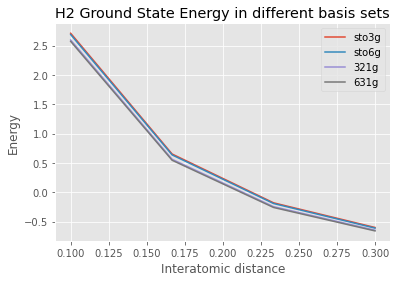

In [11]:
for j in range(len(basis_sets)):
    plt.plot(distances, exact_energies[j], label=basis_sets[j])
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.title('H2 Ground State Energy in different basis sets')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#tikzplotlib.save("test.tex")